## Setup

To explore $TD(\lambda)$ in the tabular setting, we'll be working with the (slightly modified) Frozen Lake task again; see the $\texttt{Value Iteration and Policy Iteration}$ notebook for details.

In [4]:
from frozen_lake import FrozenLakeEnv
import dill
env = FrozenLakeEnv()
#Import MDP object for Frozen Lake environment
with open('FrozenLakeMDP.pkl', 'rb') as input:
  mdp = dill.load(input)

In [5]:
# Some basic imports and setup
%matplotlib inline
import numpy as np, numpy.random as nr, gym, copy
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=3)

In [6]:
ALPHA = 1 #Discount factor

## TD($\lambda$) policy evaluation (NDP p.195 - 198)

In this section, we will implement the offline $TD(\lambda)$ algorithm for policy evaluation, discussed on pages 195-198 of the NDP book.  We'll look at the differences between the fist- and every-visit methods, as well as the effects of varying $\lambda$, as applied to the Frozen Lake task.   

In [7]:
def offlineTDL(alpha, lambda_, nEp, pi, everyVisit=False):
  '''  
  Inputs
    alpha: discount factor
    lambda_: lambda from TD(lambda)
    mdp: MDP object
    nEp: number of episodes 
    pi: policy (function from s to a)
    everyVisit: boolean for everyVisit method
  Outputs
    VList: list of estimated V-functions from each episode
  '''
  VList = []            
  V = np.zeros(mdp.nS)  #Initialize value function 
  env = FrozenLakeEnv()
  for ep in range(nEp):
    visitDict = {s:np.array([]) for s in range(mdp.nS)} #Counts steps since each visit to state
    Vupdate = np.zeros(mdp.nS)     #Accumulates TD errors at each state
    done = False
    s = env.reset()
    while not done:         
        #Get next action, state, reward, and TD error
        a = pi(s)
        sp, _, done, _ = env.step(a)
        r = -0.001 * (sp != 15) + (sp == 15)
        d = r + alpha*V[sp] - V[s]
        
        #Add visit if first visit, or using every visit method
        if len(visitDict[s]) == 0 or everyVisit:
          visitDict[s] = np.append(visitDict[s], 0)       
        #Add to Vupdate 
        for s_ in range(mdp.nS):
          Vupdate[s_] += np.sum(lambda_**visitDict[s_]) * d  
          visitDict[s_] += np.ones(len(visitDict[s_]))
        s = sp 
    V += (nEp+1)**(-0.75) * Vupdate  #Update V 
    VList.append(copy.copy(V))
  return VList     

Next we'll test out the first- and every-visit variants of the algorithm, with varying values of $\lambda$, by evaluating a policy on the Frozen Lake task.  We'll evaluate the optimal policy, found using the $\texttt{policy_iteration}$ function I've defined in $\texttt{policy_iteration.py}$.  

After defining some functions to help us plot the V-function iterates at each episode, we run the algorithm for $\lambda \in \{0, 0.5, 0.9, 1 \}$ for both the first- and every-visit methods, and plot the results.

In [8]:
#Get policy to evaluate
#  policy_iteration returns list of V-functions and optimal policies from 
#  each iteration
from policy_iteration import policy_iteration
VList_PI, policyList = policy_iteration(ALPHA, mdp, nIt=20)
pi = lambda s: policyList[-1][s]

In [13]:
def axisPlotter(ax, lambda_, VList): 
  title = 'Lambda = {}'.format(lambda_)    
  ax.set_xlabel('Episode')
  ax.set_ylabel('State value estimate')
  ax.set_title(title)
  ax.plot(VList)  

def plotVFs(alpha, everyVisit, lambdas, nEp):
  nlambda = len(lambdas)
  everyVisitStr = ['First Visit', 'Every Visit']
  print(everyVisitStr[everyVisit])
  fig, axes = plt.subplots(1, nlambda, sharex=True, sharey=True, figsize=(5,20))
  for j in range(nlambda):
    VList = offlineTDL(ALPHA, lambdas[j], nEp, pi, everyVisit=everyVisit)
    ax = axes[j] 
    axisPlotter(ax, lambdas[j], VList)
  plt.tight_layout()
  plt.show()

First Visit


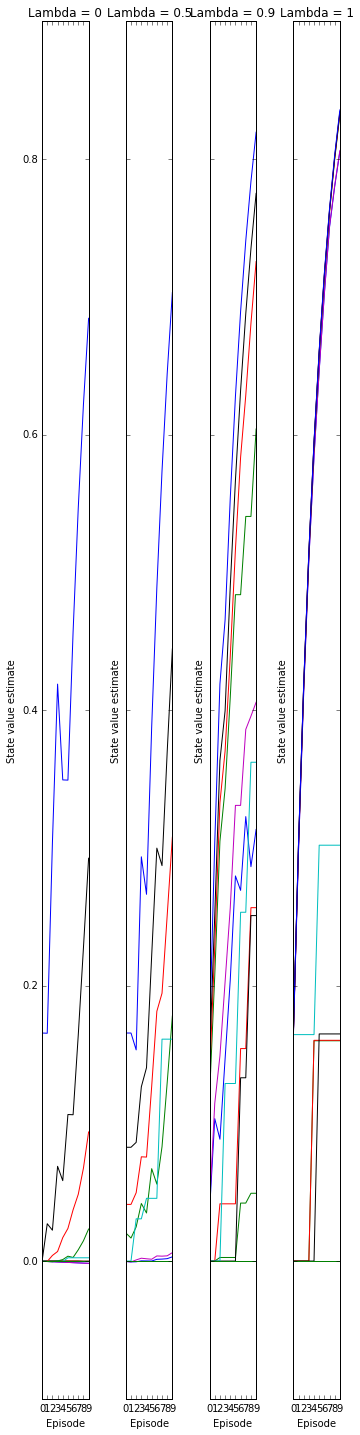

Every Visit


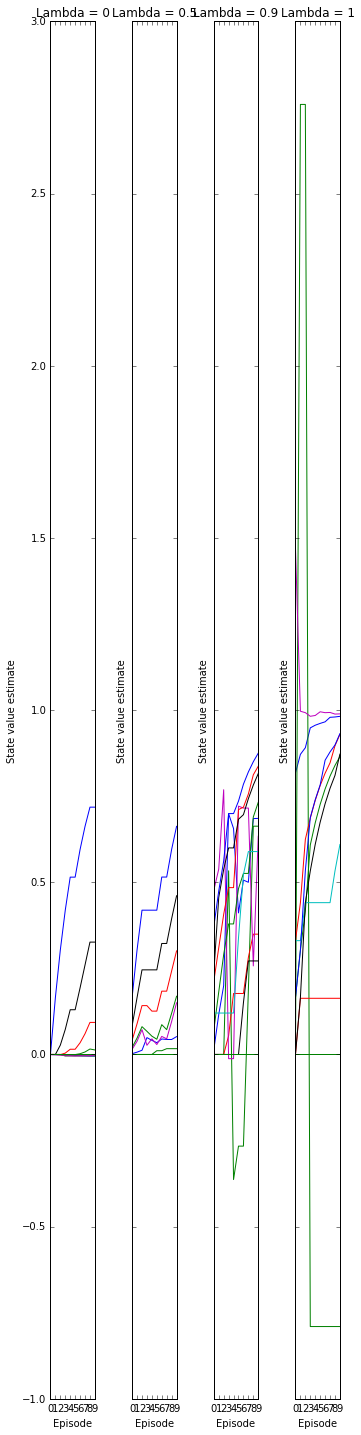

In [14]:
ALPHA = 1
nEp = 10
lambdas = [0, 0.5, 0.9, 1]
plotVFs(ALPHA, False, lambdas, nEp)
plotVFs(ALPHA, True,  lambdas, nEp)

In [ ]:
plotTDL(ALPHA, True,  lambdas, nEp)